### Calculating Fly Hairiness

The general strategy is to find the luminance peaks across several image transects of SEM images for different body parts of the fly. For thorax, abdomen, and wing images, we choose four non-overlapping quadrants. For each quadrant we calculate the number of hairs crossing 12 transects at 30 deg increments, and choose the largest value, which corresponds to the transect perpendicular to the mean hair orientation. Then we take the average of these values for the four quadrants. For the oilfly's abdomen, we manually specified two quadrants, since the image did not fill the frame.

For leg images, we manually specified four transects for each fly, to ensure that the transects span the leg, and are perpendicular to the hair orientation.

Based on this approach, 'hairiness' is defined as the average number of hairs crossing a transect, which is correlated with both hair density, and hair length. For example, suppose we have two flies with the same hair folicle density but with different hair lengths. The fly with longer hairs will yield more hair crossings for a given transect.

In [1]:
import numpy as np
import cv2
import scipy.ndimage
import matplotlib.pyplot as plt
import scipy.signal
import matplotlib.pyplot as plt
import fly_plot_lib.plot as fpl
%matplotlib inline

1.5.1
recommended version: 1.1.1 or greater


### Peak finding algorithm

In [2]:
import sys
from numpy import NaN, Inf, arange, isscalar, asarray, array

def peakdet(v, delta, x = None):
    """
    Converted from MATLAB script at http://billauer.co.il/peakdet.html
    
    Returns two arrays
    
    function [maxtab, mintab]=peakdet(v, delta, x)
    %PEAKDET Detect peaks in a vector
    %        [MAXTAB, MINTAB] = PEAKDET(V, DELTA) finds the local
    %        maxima and minima ("peaks") in the vector V.
    %        MAXTAB and MINTAB consists of two columns. Column 1
    %        contains indices in V, and column 2 the found values.
    %      
    %        With [MAXTAB, MINTAB] = PEAKDET(V, DELTA, X) the indices
    %        in MAXTAB and MINTAB are replaced with the corresponding
    %        X-values.
    %
    %        A point is considered a maximum peak if it has the maximal
    %        value, and was preceded (to the left) by a value lower by
    %        DELTA.
    
    % Eli Billauer, 3.4.05 (Explicitly not copyrighted).
    % This function is released to the public domain; Any use is allowed.
    
    """
    maxtab = []
    mintab = []
       
    if x is None:
        x = arange(len(v))
    
    v = asarray(v)
    
    if len(v) != len(x):
        sys.exit('Input vectors v and x must have same length')
    
    if not isscalar(delta):
        sys.exit('Input argument delta must be a scalar')
    
    if delta <= 0:
        sys.exit('Input argument delta must be positive')
    
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    
    lookformax = True
    
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True

    return array(maxtab), array(mintab)

### Extract hairiness functions

In [3]:
def get_pts_from_angle(angle, x, y, length):
    x1 = x - length/2.*np.sin(angle*np.pi/180.)
    x2 = x + length/2.*np.sin(angle*np.pi/180.)
    y1 = y - length/2.*np.cos(angle*np.pi/180.)
    y2 = y + length/2.*np.cos(angle*np.pi/180.)
    return [x1, y1], [x2, y2]

def get_inter_hair_distances(metadata, pt1, pt2, plot=False, require_peak_luminance=150, debug=False):
    filename = metadata['filename']
    pixels_per_micron = metadata['scale'][0] / float(metadata['scale'][1])
    
    img = cv2.imread(filename)
    img = img[0:670,:] # ignore the SEM metadata portion at the bottom
    img = img[:,:,0]

    #-- Extract the line...
    # Make a line with "num" points...

    length = np.linalg.norm(np.array(pt1) - np.array(pt2))
    num = length
    x1, y1 = pt1
    x2, y2 = pt2
    
    x, y = np.linspace(x1, x2, num), np.linspace(y1, y2, num)

    # Extract the values along the line, using cubic interpolation
    zi = scipy.ndimage.map_coordinates(img, np.vstack((y,x)))

    # check luminance across transect - there must be at least 1 hair!
    if np.max(zi) < require_peak_luminance:
        if debug:
            print 'Skipping angle...'
            print '     Peak Luminance Failed: ', metadata['filename']
            print '     Luminance: ', np.max(zi)
            print '     Points: ', pt1, pt2 
        return 0
    

    wn = 1
    b, a = scipy.signal.butter(3, wn)
    zi = scipy.signal.filtfilt(b,a,zi)

    if 'wing' in metadata['filename']:
        std_factor = 2
    else:
        std_factor = 1
    
    peaks = peakdet(zi, np.std(zi)*std_factor, x = None)
    
    
    if plot:
        fig = plt.figure(figsize=(25,25))
        axes = [fig.add_subplot(211), fig.add_subplot(212)]
        axes[0].imshow(img, cmap='gray')
        fpl.adjust_spines(axes[0], [])
        axes[0].plot([x1, x2], [y1, y2], 'ro-')
        axes[0].axis('image')

        axes[1].plot(zi)
        axes[1].plot(peaks[0][:,0], peaks[0][:,1], 'o')
        fpl.adjust_spines(axes[1], [])

    num_peaks = len(peaks[0])
    num_peaks_per_pixel = num_peaks / float(length)
    num_peaks_per_micron = num_peaks_per_pixel*pixels_per_micron
    
    return num_peaks_per_micron

def get_peaks_per_micron_manual_count(metadata, pt1, pt2, num_peaks, plot=False):
    if plot:
        d = get_inter_hair_distances(metadata, pt1, pt2, plot=True)
    
    length = np.linalg.norm(np.array(pt1) - np.array(pt2))
    num_peaks_per_pixel = num_peaks / float(length)
    num_peaks_per_micron = num_peaks_per_pixel*pixels_per_micron
    return num_peaks_per_micron

def get_transect_data(image_metadata):
    data = []
    for i in range(len(image_metadata['transects'])):
        d = get_inter_hair_distances(    image_metadata, 
                                         image_metadata['transects'][i][0],
                                         image_metadata['transects'][i][1],
                                         plot=False)
        data.append(d)
    
    return np.mean(data)

def get_angle_data(image_metadata):
    
    def spin_angle(image_metadata, x, y, l):
        data = []
        angles = range(0,360,30)
        for a in angles:
            pt1, pt2 = get_pts_from_angle(a, x, y, l)
            d = get_inter_hair_distances(    image_metadata, 
                                             pt1,
                                             pt2,
                                             plot=False)
            data.append(d)
        
        optimal_index = np.argmax(data)
        optimal_angle = angles[optimal_index]
        return np.max(data), optimal_angle
    
    data = []
    optimal_angles = []
    
    if 'angle_spin_pts' in image_metadata.keys():
        x = image_metadata['angle_spin_pts']['x']
        y = image_metadata['angle_spin_pts']['y']
        l = image_metadata['angle_spin_pts']['l']
    else:
        x = [200, 750, 200, 750]
        y = [200, 200, 450, 450]
        l = [300, 300, 300, 300]
    
    for i in range(len(x)):
        d, a = spin_angle(image_metadata, x[i], y[i], l[i])
        data.append(d)
        optimal_angles.append(a)
        
    return np.mean(data), optimal_angles

def get_data_for_image_metadata(image_metadata):
    if 'transects' in image_metadata.keys():
        return get_transect_data(image_metadata)
    else:
        d, angles = get_angle_data(image_metadata)
        return d

### Iterate over species and bodyparts

In [4]:
manual_counting_data = {'blackkelp': {'lowerleg': [0.09,.087,.11],
                                      },
                         }

In [5]:
import image_metadata

def get_hairyness_for_species_bodypart(species, bodypart):
    metadata = eval('image_metadata.' + species + '_' + bodypart)
    d = get_data_for_image_metadata(metadata)
    return d

def get_hairyness_for_bodyparts(species):
    bodyparts = ['abdomen', 'thorax', 'wing', 'lowerleg']
    data = {}
    for bodypart in bodyparts:
        try:
            h = np.mean(manual_counting_data[species][body[art]])
        except:
            h = get_hairyness_for_species_bodypart(species, bodypart)
        data[bodypart] = h
    return data

def get_mean_hairyness_for_species(data, species):
    d = [v for v in data[species].values() if type(v) != str]
    return np.mean(d)

def get_all_hairyness():
    data = {}
    for species in ['ephydra', 'bluekelp', 'blackkelp', 'oilfly', 'santaana', 'melanogaster', 'virilis']:
        print species
        data[species] = get_hairyness_for_bodyparts(species)
        print '   hairyness: ', get_mean_hairyness_for_species(data, species)
    return data
    
    
def get_hairyness_for_species_and_bodypart_from_saved_data(pd, species, bodypart):
    if bodypart == 'all':
        return (pd[pd.species==species].mean(axis=1).values[0])
    else:
        return (pd[pd.species==species][bodypart].values[0])

### Calculate all the hairyness values - takes a while.

In [6]:
data = get_all_hairyness()
for species in ['ephydra', 'bluekelp', 'blackkelp', 'oilfly', 'santaana', 'melanogaster', 'virilis']:
    data[species]['species'] = species # add species name tag, for pandas organization

ephydra
   hairyness:  0.3129361669
bluekelp
   hairyness:  0.271905248818
blackkelp
   hairyness:  0.201025895094
oilfly
   hairyness:  0.197399110176
santaana
   hairyness:  0.253196291595
melanogaster
   hairyness:  0.205456635598
virilis
   hairyness:  0.254979791752


### Save data to pandas

In [7]:
import pandas

pd_df = pandas.DataFrame()
for species in ['ephydra', 'bluekelp', 'blackkelp', 'oilfly', 'santaana', 'melanogaster', 'virilis']:
    pd_df = pd_df.append(data[species], ignore_index=True)
pd_df.to_pickle('species_hairiness.pickle')

### Print average hairyness

In [8]:
hairiness = []
for species in ['bluekelp', 'blackkelp', 'ephydra', 'santaana', 'oilfly', 'melanogaster', 'virilis']:
    h = get_mean_hairyness_for_species(data, species)
    print species, h
    hairiness.append(h)
    

bluekelp 0.271905248818
blackkelp 0.201025895094
ephydra 0.3129361669
santaana 0.253196291595
oilfly 0.197399110176
melanogaster 0.205456635598
virilis 0.254979791752


### Example of hairyness calculation for:
- Abdomen
- Thorax
- Wing

### Instructions
1. Choose species and bodypart. 
2. (optional) Find the optimal angle to calculate hairness at (hard coded to 30 deg increments) for the four primary test quadrants. 
3. Choose a quadrant (0,1,2,3) to display the results. Or, set use_quadrant equal to -1 and manually set X, Y, L, and ANGLE

In [9]:
def make_transect_plot(use_quadrant, species, bodypart):
    # processing / plotting code
    import image_metadata
    reload(image_metadata)
    
    d, optimal_angles = get_angle_data(eval('image_metadata.' + species + '_' + bodypart))
    print 'Optimal Angles for 4 quadrants: ', optimal_angles

    # if use_quadrant not between 0 and 3, then algorithm uses these parameters:
    X = 200; Y = 200; L = 300; ANGLE = 90

    default_quadrants = {'x': [200, 750, 200, 750],
                         'y': [200, 200, 450, 450],
                         'l': [300, 300, 300, 300]}

    IM = eval('image_metadata.' + species + '_' + bodypart)
    if use_quadrant in range(0,4): # use a hard coded quadrant
        x = default_quadrants['x'][use_quadrant]
        y = default_quadrants['y'][use_quadrant]
        l = default_quadrants['l'][use_quadrant]
        angle = optimal_angles[use_quadrant]
        
        if 'angle_spin_pts' in IM.keys():
            x = IM['angle_spin_pts']['x'][use_quadrant]
            y = IM['angle_spin_pts']['y'][use_quadrant]
            l = IM['angle_spin_pts']['l'][use_quadrant]

    else:
        x = X
        y = Y
        l = L
        angle = ANGLE
        
    

    pt1, pt2 = get_pts_from_angle(angle, x, y, l) # args: angle, x, y, transect length
    d = get_inter_hair_distances(    eval('image_metadata.' + species + '_' + bodypart),
                                     pt1,
                                     pt2,
                                     plot=True)
    print d

## Ephydra Wing

Optimal Angles for 4 quadrants:  [120, 90, 60, 240]
0.14


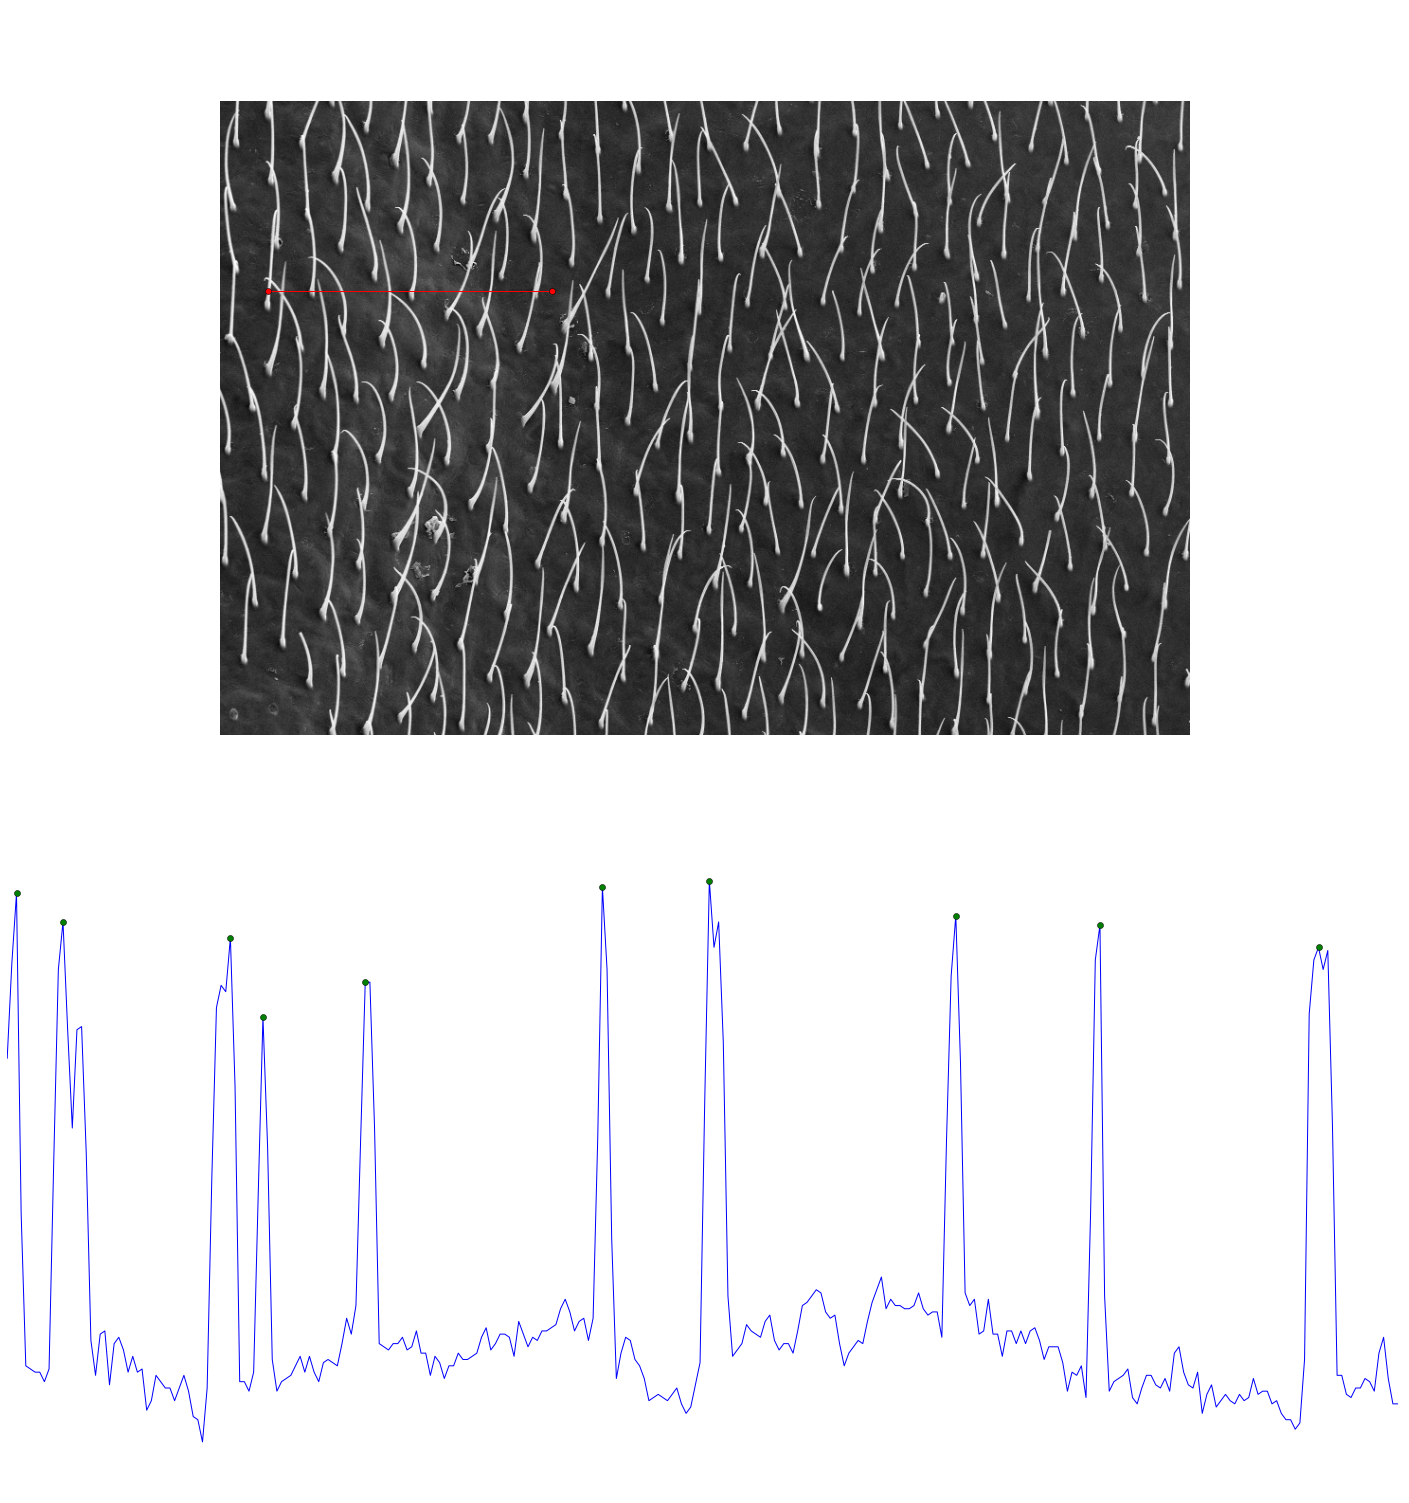

In [10]:
# user specified parameters:
use_quadrant = 4
species = 'ephydra' # choose: ['ephydra', 'bluekelp', 'blackkelp', 'oilfly', 'santaana', 'melanogaster', 'virilis']
bodypart = 'wing' # choose: ['abdomen', 'thorax', 'wing']
make_transect_plot(use_quadrant, species, bodypart)

#### ^ Ephydra Wing.
Top: SEM image of Ephydra wing. Red line shows the chosen transect.
Bottom: Image luminosity across the transect, green points indicate automatically detected peaks.

## Black Kelp Thorax

Optimal Angles for 4 quadrants:  [330, 150, 120, 150]
0.364


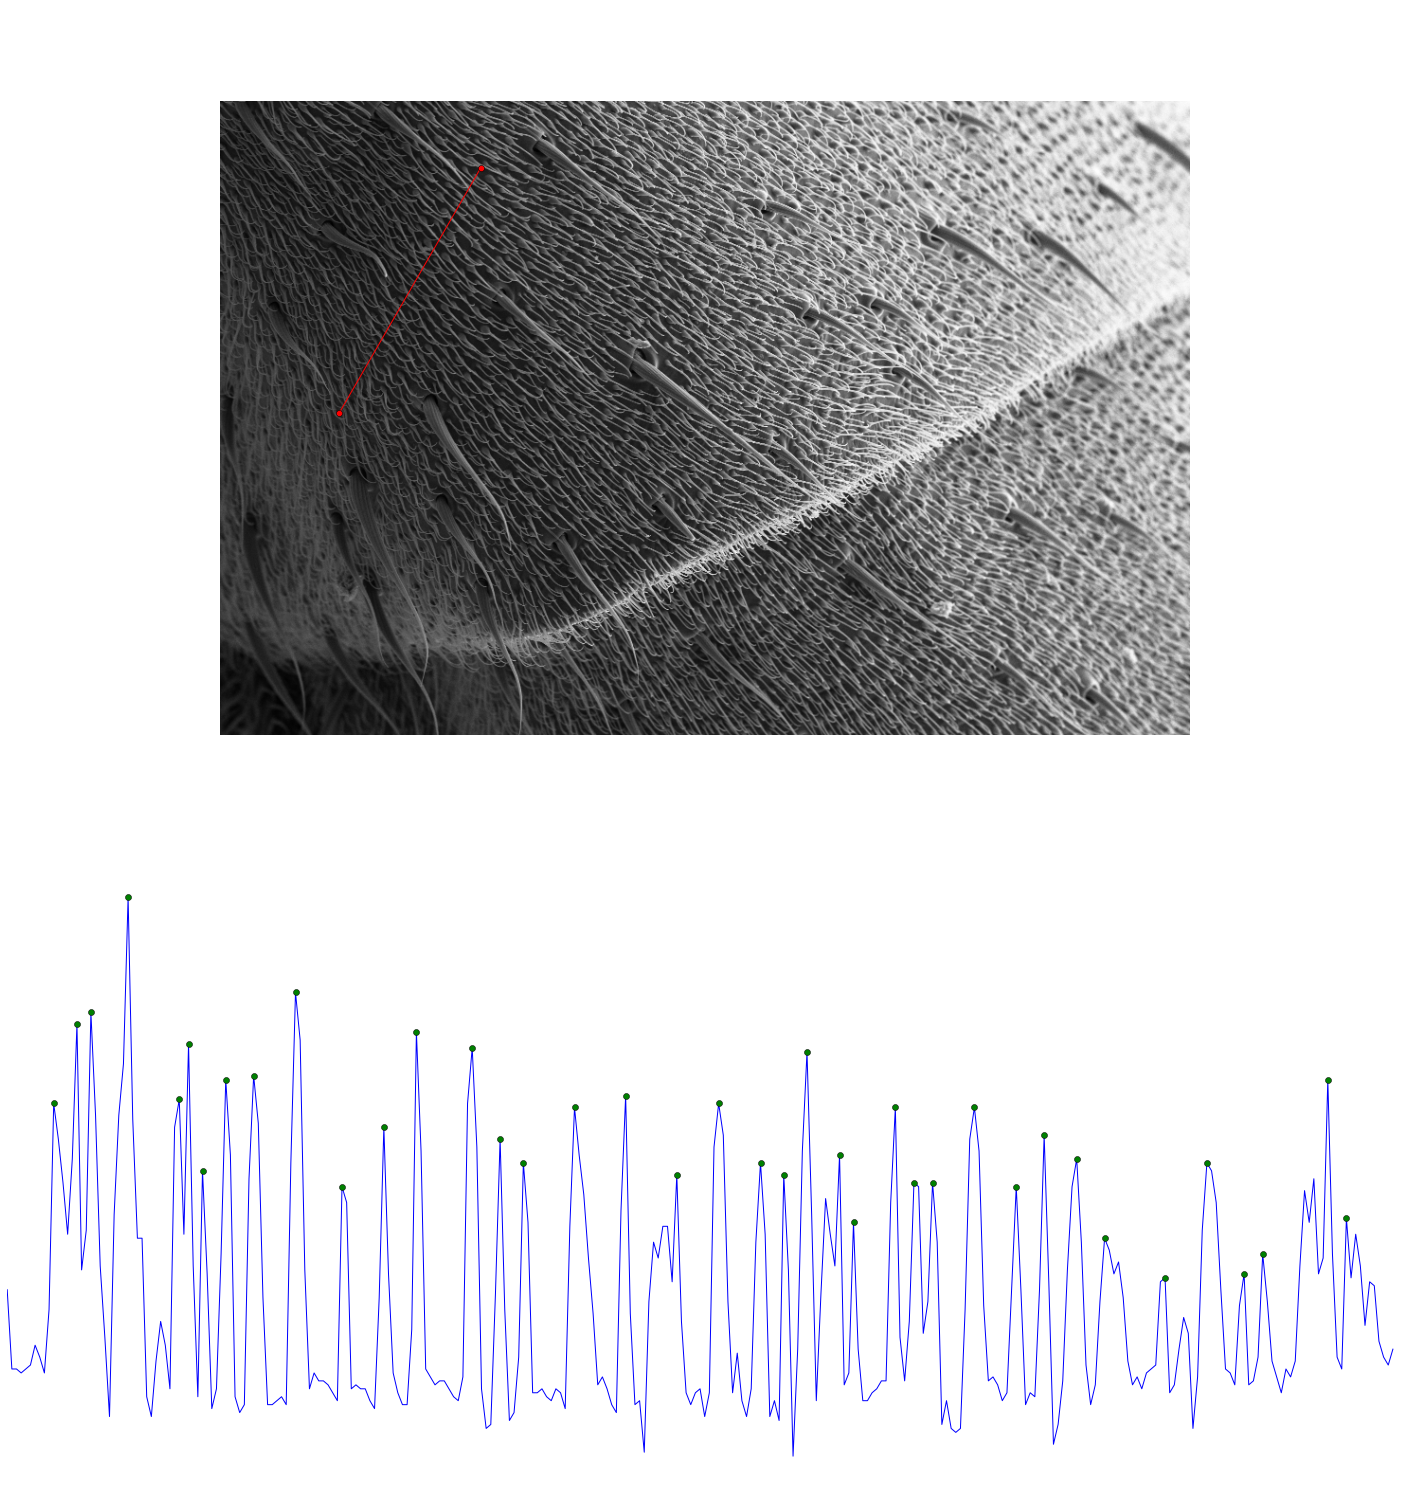

In [11]:
# user specified parameters:
use_quadrant = 0
species = 'blackkelp' # choose: ['ephydra', 'bluekelp', 'blackkelp', 'oilfly', 'santaana', 'melanogaster', 'virilis']
bodypart = 'abdomen' # choose: ['abdomen', 'thorax', 'wing']
make_transect_plot(use_quadrant, species, bodypart)

#### ^ Black Kelp Thorax.
Top: SEM image. Red line shows the chosen transect.
Bottom: Image luminosity across the transect, green points indicate automatically detected peaks.

### Example of hairyness calculation for: lowerleg

In [12]:
def make_transect_plot_lowerleg(transect, species, num_peaks=None):
    import image_metadata
    
    metadata = eval('image_metadata.' + species + '_lowerleg')
    pt1 = eval('image_metadata.' + species + '_lowerleg')['transects'][transect][0]
    pt2 = eval('image_metadata.' + species + '_lowerleg')['transects'][transect][1]

    if num_peaks is None:
        d = get_inter_hair_distances(metadata, pt1, pt2, plot=True)
    else:
        d = get_peaks_per_micron_manual_count(metadata, pt1, pt2, num_peaks, plot=True)
    
    print d

## Ephydra Lower Leg

0.27554648262
pixels per micron:  5.6


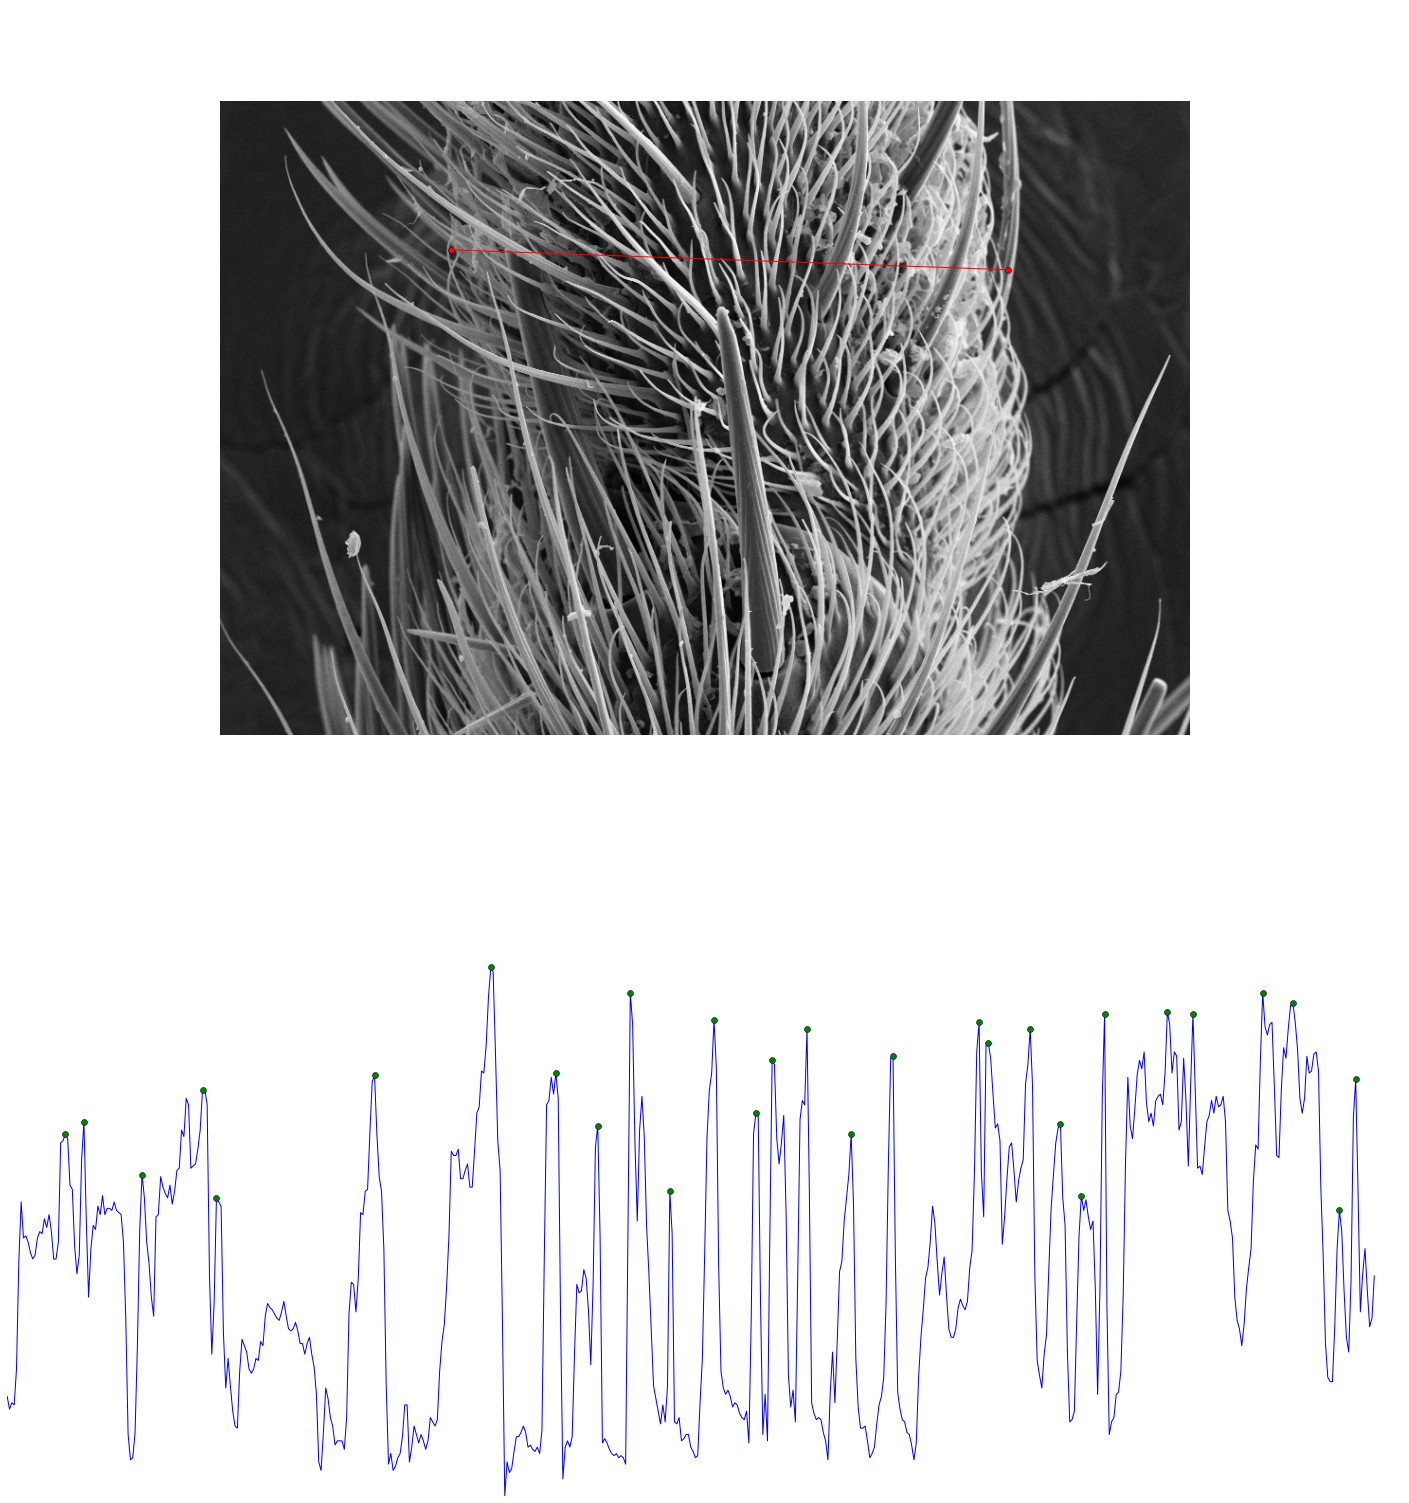

In [13]:
species = 'ephydra'
transect = 1
make_transect_plot_lowerleg(transect, species)

import image_metadata
metadata = eval('image_metadata.' + species + '_lowerleg')
pixels_per_micron = metadata['scale'][0] / float(metadata['scale'][1])
print 'pixels per micron: ', pixels_per_micron

## Santa Ana Lower Leg

0.294663574534
pixels per micron:  8.5


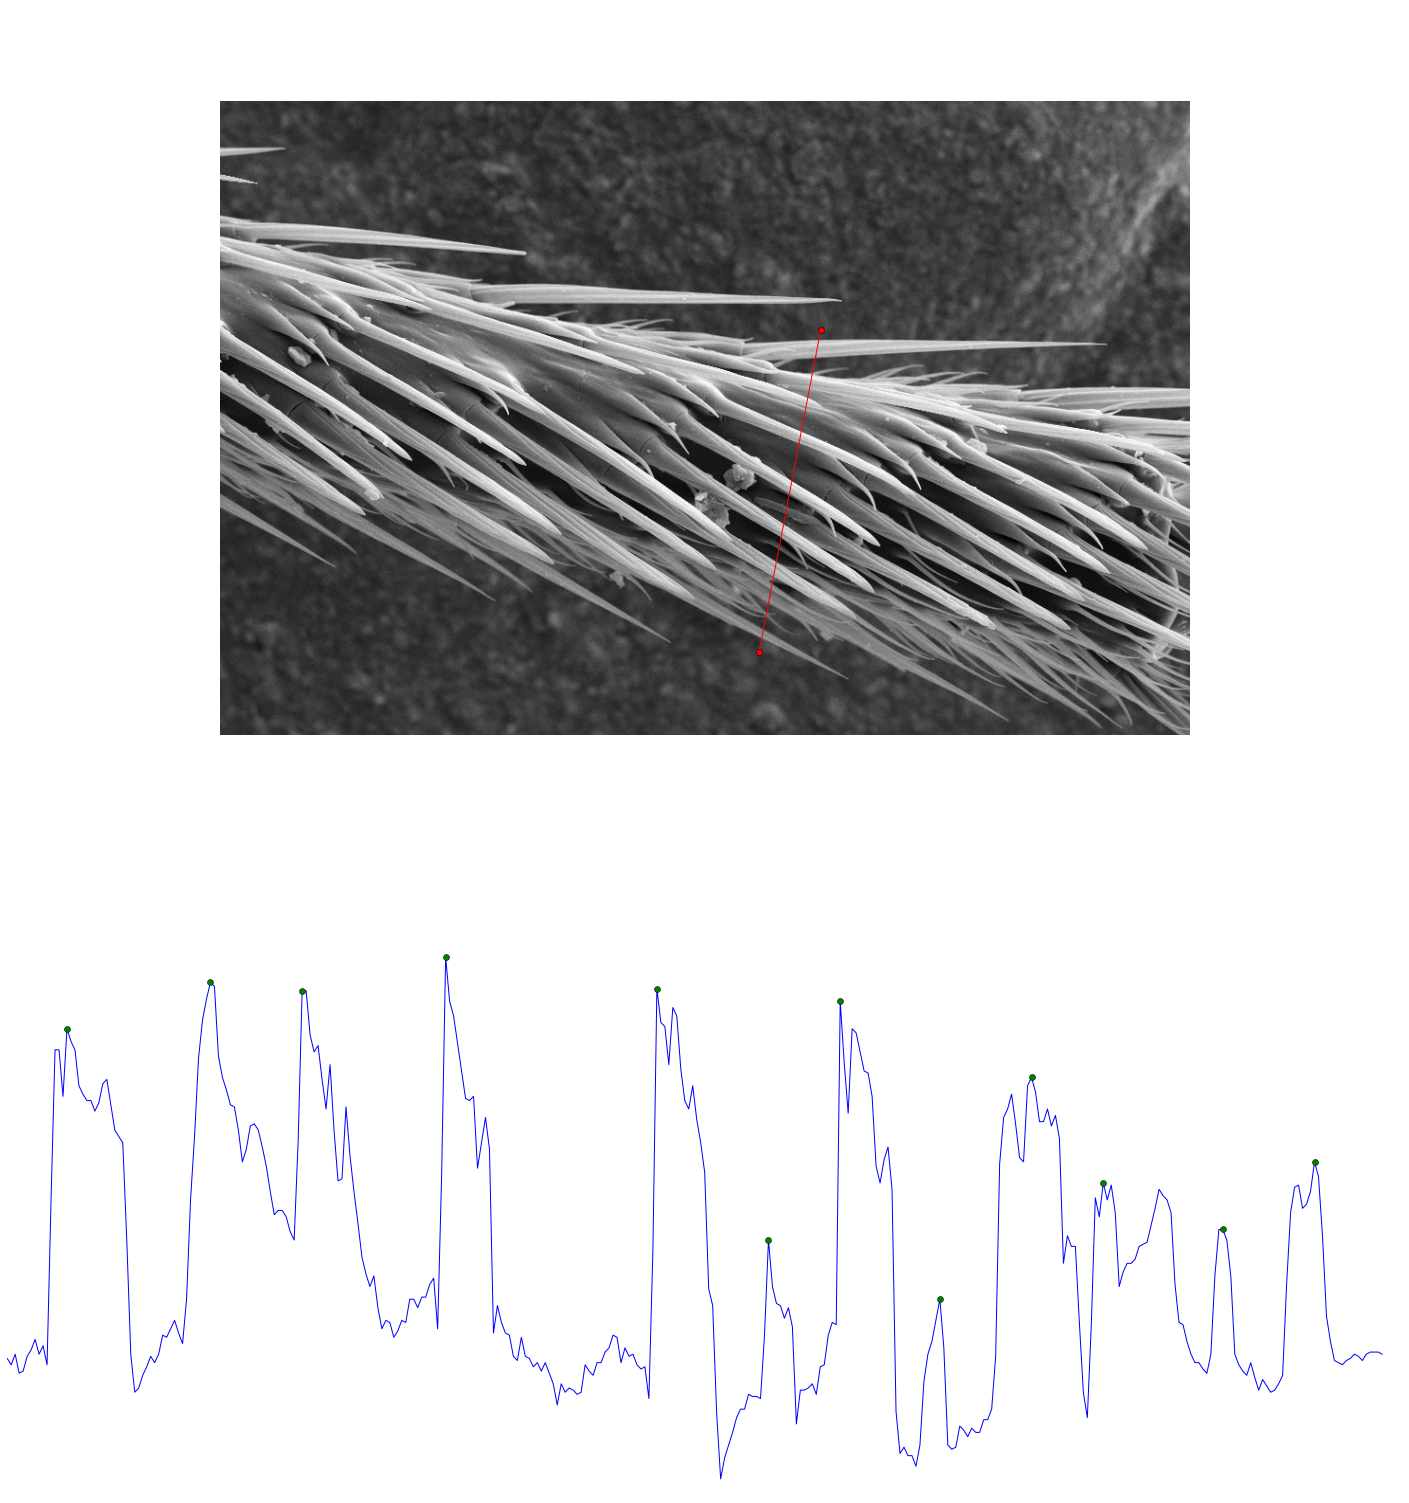

In [14]:
species = 'santaana'
transect = 2
make_transect_plot_lowerleg(transect, species)


import image_metadata
metadata = eval('image_metadata.' + species + '_lowerleg')
pixels_per_micron = metadata['scale'][0] / float(metadata['scale'][1])
print 'pixels per micron: ', pixels_per_micron

In [15]:
def plot_mean_hairyness_values(ax, bodypart, cmap='jet'):
    species_order = ['bluekelp', 'blackkelp', 'ephydra', 'santaana', 'oilfly', 'melanogaster', 'virilis']
    
    pd = pandas.read_pickle('species_hairiness.pickle')
    
    h = []
    for species in species_order:
        if bodypart == 'all':
            h.append(pd[pd.species==species].mean(axis=1).values[0])
        else:
            h.append(pd[pd.species==species][bodypart].values[0])
    
    h = np.array(h).reshape([len(h),1])
    
    ax.imshow(h, cmap=cmap, 
              interpolation='nearest', 
              origin='upper', 
              extent=[0,1,0,len(species_order)])
    
    if bodypart == 'wing':
        fpl.adjust_spines(ax, ['left'], yticks=np.arange(0.5, 7))
        ax.set_yticklabels(species_order[::-1])
        ax.set_title('wing')
    else:
        fpl.adjust_spines(ax, [])
        ax.set_title(bodypart)

    abdomen  lowerleg       species    thorax      wing
0  0.340417  0.294911       ephydra  0.451917  0.164500
1  0.375750  0.234121      bluekelp  0.348750  0.129000
2  0.315000  0.195104     blackkelp  0.186667  0.107333
3  0.081000  0.367346        oilfly  0.218250  0.123000
4  0.182000  0.301118      santaana  0.389667  0.140000
5  0.142333  0.189993  melanogaster  0.373333  0.116167
6  0.287000  0.255586       virilis  0.357750  0.119583


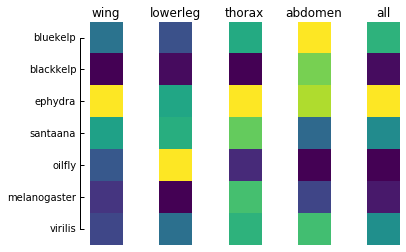

In [16]:
import fly_plot_lib.plot as fpl # https://github.com/florisvb/FlyPlotLib
import fly_plot_lib.colormaps

pd = pandas.read_pickle('species_hairiness.pickle')
print pd

fig = plt.figure()
axes = {'wing': fig.add_subplot(151), 
        'lowerleg': fig.add_subplot(152), 
        'thorax': fig.add_subplot(153), 
        'abdomen': fig.add_subplot(154), 
        'all': fig.add_subplot(155)}
for bodypart, ax in axes.items():
    plot_mean_hairyness_values(ax, bodypart, cmap=fly_plot_lib.colormaps.viridis)
    


### Display the relative increase in hairiness of the Mono Lake fly compared to other species

In [17]:
bodypart = 'all'

hairiness_ephydra = 0
hairiness_not_ephydra = []
species_order = ['bluekelp', 'blackkelp', 'ephydra', 'santaana', 'oilfly', 'melanogaster', 'virilis']
pd = pandas.read_pickle('species_hairiness.pickle')
for species in species_order:
    h = get_hairyness_for_species_and_bodypart_from_saved_data(pd, species, bodypart)
    if species == 'ephydra':
        hairiness_ephydra = h
    else:
        hairiness_not_ephydra.append(h)
hairiness_not_ephydra = np.mean(hairiness_not_ephydra)

print (hairiness_ephydra - hairiness_not_ephydra) / hairiness_not_ephydra 

0.356695979578
